# Аналіз Транспортних Мереж: Від Пошуку Шляхів до Оптимізації Маршрутів

## Попередні налаштування: підготовка середовища та визначення функцій

In [6]:
# Комірка для імпорту всіх необхідних бібліотек
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np
from collections import deque
import heapq
from typing import List, Tuple, Dict, Optional, Iterable
import pandas as pd
from IPython.display import display
import time

### DFS

In [2]:
def dfs_iterative(G: nx.Graph, src: str, dst: str) -> List[str]:
    """Повертає *a* шлях, знайдений за допомогою пошуку в глибину (стек LIFO).

    Зупиняється на першому входженні *dst*; не обов'язково найкоротшому.
    Реалізовано без рекурсії, щоб уникнути переповнення стеку на великих графах.
    """
    if src not in G or dst not in G:
        raise KeyError("Both src and dst must exist in the graph.")

    stack: List[Tuple[str, List[str]]] = [(src, [src])]
    visited: set[str] = set()

    while stack:
        node, path = stack.pop()
        if node == dst:
            return path
        if node in visited:
            continue
        visited.add(node)
        # Додаємо сусідів у стек у зворотному порядку, щоб обхід був більш "природнім"
        for neigh in reversed(list(G.neighbors(node))): 
            if neigh not in visited:
                stack.append((neigh, path + [neigh]))
    raise nx.NetworkXNoPath(f"No path from {src!r} to {dst!r} found.")

### BFS

In [3]:
def bfs_iterative(G: nx.Graph, src: str, dst: str) -> List[str]:
    """Повертає *найкоротший* шлях за кількістю ребер з використанням BFS (черга FIFO)"""
    if src not in G or dst not in G:
        raise KeyError("Both src and dst must exist in the graph.")

    queue: deque[Tuple[str, List[str]]] = deque([(src, [src])])
    visited: set[str] = {src}

    while queue:
        node, path = queue.popleft()
        if node == dst:
            return path
        for neigh in G.neighbors(node):
            if neigh not in visited:
                visited.add(neigh)
                queue.append((neigh, path + [neigh]))
    raise nx.NetworkXNoPath(f"No path from {src!r} to {dst!r} found.")

### Алгоритм Дейкстри

In [4]:
def dijkstra_heap(G: nx.Graph, src: str, dst: str, weight: str = "time") -> Tuple[List[str], float]:
    """Найкоротший шлях за сумарною *вагою* з використанням Дейкстри + двійкова купа.
    Повертає кортеж з шляху та його ваги.
    Використовує `heapq` для оптимізації пошуку мінімального елемента.
    """
    if src not in G or dst not in G:
        raise KeyError(f"Node {src if src not in G else dst} not in graph.")


    # Distance table and predecessor map
    dist: Dict[str, float] = {node: float("inf") for node in G.nodes}
    prev: Dict[str, str | None] = {node: None for node in G.nodes}

    dist[src] = 0.0
    # heapq працює як мін-купа
    pq: List[Tuple[float, str]] = [(0.0, src)] 

    while pq:
        d, node = heapq.heappop(pq) # Використовуємо heapq.heappop
        if node == dst:
            break
        if d > dist[node]:
            continue  # Stale entry
        for neigh, attrs in G[node].items():
            w = attrs.get(weight, 1.0) # Отримуємо вагу, по дефолту 1.0 якщо не вказана
            if w is None: # Обробка випадку, якщо вага відсутня для ребра
                w = 1.0 
            nd = d + float(w) # Переконуємось, що вага є числом
            if nd < dist[neigh]:
                dist[neigh] = nd
                prev[neigh] = node
                heapq.heappush(pq, (nd, neigh)) # Використовуємо heapq.heappush

    if dist[dst] == float("inf"):
        raise nx.NetworkXNoPath(f"No path from {src!r} to {dst!r} using Dijkstra.")

    # Reconstruct path
    rev_path: List[str] = []
    cur: Optional[str] = dst # cur може бути None
    while cur is not None:
        rev_path.append(cur)
        cur = prev[cur]
    path = list(reversed(rev_path))
    return path, dist[dst]

### Візуалізація

In [7]:
def plot_graph_custom(G: nx.Graph, highlighted_path: Iterable[str] | None = None, *, title: str = "City transport graph", ax: plt.Axes | None = None, pos: Dict | None = None, node_labels_viz: Dict | None = None, edge_labels_attr: str | None = None) -> None:
    """Побудова графіку, використовуючи вказаний макет або макет пружини (spring layout).

    Параметри
    ----------
    G : nx.Graph
        Граф для візуалізації.
    highlighted_path : Iterable[str] | None, optional
        Шлях для виділення на графіку. Якщо None, шлях не виділяється.
    title : str, default "City transport graph"
    ax : plt.Axes | None, default None
        Вісі для побудови графіку. Якщо None, створюється нова фігура.
    pos : Dict | None, default None
        Позиції вузлів для візуалізації. Якщо None, використовується макет пружини (spring layout).
    node_labels_viz : Dict | None, default None
        Словник міток вузлів для візуалізації. Якщо None, використовуються імена вузлів.
    edge_labels_attr : str | None, default None
        Атрибут ребер для візуалізації. Якщо None, ребра не мають міток.
    """

    if ax is None:
        _, ax = plt.subplots(figsize=(10, 8))

    current_pos = pos if pos is not None else nx.spring_layout(G, seed=42)
    labels_to_draw = node_labels_viz if node_labels_viz else None
    
    nx.draw(G, current_pos, ax=ax, labels=labels_to_draw, with_labels=True,
            node_size=3000, node_color="lightcoral", font_size=8, font_weight="bold", width=1.5, alpha=0.8)

    if highlighted_path:
        path_edges = list(zip(list(highlighted_path), list(highlighted_path)[1:]))
        nx.draw_networkx_nodes(G, current_pos, nodelist=list(highlighted_path), node_color='gold', node_size=3500, ax=ax)
        nx.draw_networkx_edges(G, current_pos, edgelist=path_edges, edge_color='red', width=2.5, ax=ax)

    if edge_labels_attr:
        edge_labels = nx.get_edge_attributes(G, edge_labels_attr)
        formatted_edge_labels = {k: f"{v} хв" if isinstance(v, (int, float)) else str(v) for k, v in edge_labels.items()}
        nx.draw_networkx_edge_labels(G, current_pos, edge_labels=formatted_edge_labels, font_color='darkgreen', font_size=7, ax=ax)

    ax.set_title(title)
    ax.axis("off")

## Розділ 1: Вступ – Моделювання міської транспортної системи
### 1.1. Транспортні мережі як графи
Транспортні системи, будь то мережа доріг, система громадського транспорту чи авіасполучення, за своєю суттю є мережами. Теорія графів надає ідеальний інструментарій для їх моделювання, де вузли можуть представляти міста, перехрестя, станції чи аеропорти, а ребра – дороги, маршрути або рейси, що їх з'єднують. Таке представлення дозволяє застосовувати потужні алгоритми для аналізу зв'язності, пошуку маршрутів та оптимізації потоків.
### 1.2. Приклад: Спрощена мережа міських локацій
Для демонстрації графових алгоритмів у контексті транспорту ми розглянемо спрощену модель мережі ключових локацій у місті. Вузлами будуть популярні точки (наприклад, "Центр", "Університет", "Парк"), а ребра представлятимуть прямі транспортні сполучення між ними (наприклад, автобусні маршрути або дороги).\
Припустимо, наша мережа складається з наступних локацій та сполучень:
* Локації (Вузли):
    * 'A': Центральний Вокзал
    * 'B': Історичний Центр
    * 'C': Університет
    * 'D': Торговий Центр
    * 'E': Парк Відпочинку
    * 'F': Спальний Район
* Сполучення (Ребра): Ми будемо розглядати їх як двосторонні (неорієнтований граф), якщо не зазначено інше.
### 1.3. Мета: Оптимізація пересувань містом
У цьому досліджені ми побудуємо граф, що моделює транспортну мережу нашого уявного міста. Ми проаналізуємо його структуру, дослідимо, як можна дістатися з однієї точки міста до іншої, використовуючи різні стратегії пошуку шляху. Нарешті, ми додамо "вартість" пересувань (наприклад, час у дорозі) та знайдемо оптимальні маршрути. Ця історія проведе нас через три основні завдання, демонструючи застосування графових алгоритмів для вирішення практичних транспортних задач.


## Розділ 2: Побудова та аналіз транспортної мережі

### 2.1. Побудова графа за допомогою NetworkX
Для моделювання транспортної мережі створимо неорієнтований граф (nx.Graph), оскільки більшість базових транспортних сполучень (як-от дороги між двома точками або двосторонні автобусні маршрути) є двонаправленими. NetworkX надає зручні інструменти для створення таких графів.    

In [9]:
# Створення неорієнтованого графа
transport_graph = nx.Graph()

# Додавання вузлів (локацій)
nodes_data = {
    'A': {'label': 'Вокзал', 'pos': (-1, -2)},
    'B': {'label': 'Центр', 'pos': (0, 0)},
    'C': {'label': 'Університет', 'pos': (-2, 1)},
    'D': {'label': 'Торговий_центр', 'pos': (2, 1)},
    'E': {'label': 'Парк', 'pos': (1, 2)},
    'F': {'label': 'Житловий_район', 'pos': (4, 2)},
    'G': {'label': 'Лікарня', 'pos': (0, 3)},
    'H': {'label': 'Стадіон', 'pos': (-3, -1)},
    'I': {'label': 'Завод', 'pos': (-2, -3)},
    'J': {'label': 'Аеропорт', 'pos': (3, -1)}
}
for node_id, attrs in nodes_data.items():
    transport_graph.add_node(node_id, **attrs)

# Додавання ребер (транспортних сполучень)
# ('Локація1', 'Локація2')
edges_data = [
    ('B', 'C'),  # Центр - Університет
    ('B', 'E'),  # Центр - Парк
    ('B', 'A'),  # Центр - Вокзал
    ('B', 'D'),  # Центр - Торговий_центр
    ('C', 'H'),  # Університет - Стадіон
    ('E', 'G'),  # Парк - Лікарня
    ('E', 'D'),  # Парк - Торговий_центр
    ('A', 'I'),  # Вокзал - Завод
    ('A', 'H'),  # Вокзал - Стадіон
    ('J', 'D'),  # Аеропорт - Торговий_центр
    ('J', 'F'),  # Аеропорт - Житловий_район
    ('D', 'F'),  # Торговий_центр - Житловий_район
    ('G', 'F'),  # Лікарня - Житловий_район
    ('H', 'I')   # Стадіон - Завод
]
transport_graph.add_edges_from(edges_data)

print("Вузли графа (локації):", transport_graph.nodes(data=True))
print("Ребра графа (сполучення):", transport_graph.edges())

Вузли графа (локації): [('A', {'label': 'Вокзал', 'pos': (-1, -2)}), ('B', {'label': 'Центр', 'pos': (0, 0)}), ('C', {'label': 'Університет', 'pos': (-2, 1)}), ('D', {'label': 'Торговий_центр', 'pos': (2, 1)}), ('E', {'label': 'Парк', 'pos': (1, 2)}), ('F', {'label': 'Житловий_район', 'pos': (4, 2)}), ('G', {'label': 'Лікарня', 'pos': (0, 3)}), ('H', {'label': 'Стадіон', 'pos': (-3, -1)}), ('I', {'label': 'Завод', 'pos': (-2, -3)}), ('J', {'label': 'Аеропорт', 'pos': (3, -1)})]
Ребра графа (сполучення): [('A', 'B'), ('A', 'I'), ('A', 'H'), ('B', 'C'), ('B', 'E'), ('B', 'D'), ('C', 'H'), ('D', 'E'), ('D', 'J'), ('D', 'F'), ('E', 'G'), ('F', 'J'), ('F', 'G'), ('H', 'I')]


### 2.2. Візуалізація структури мережі

<Figure size 800x600 with 0 Axes>

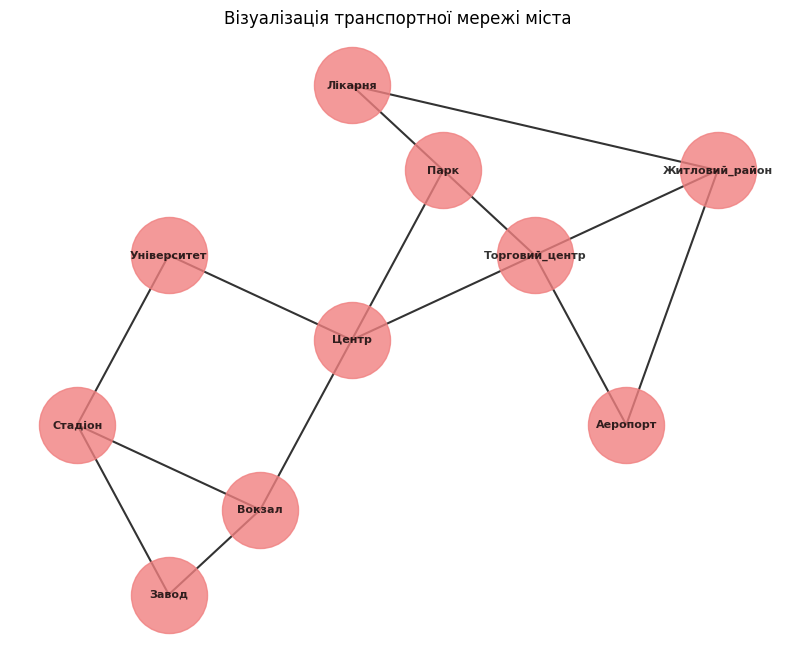

In [10]:
# Візуалізація графа
plt.figure(figsize=(8, 6))

# Отримання позицій вузлів для візуалізації
pos = nx.get_node_attributes(transport_graph, 'pos')
node_labels = nx.get_node_attributes(transport_graph, 'label')

plt.figure(figsize=(10, 8))
ax_main_graph = plt.gca()
plot_graph_custom(transport_graph, 
                  title="Візуалізація транспортної мережі міста", 
                  ax=ax_main_graph, 
                  pos=pos, 
                  node_labels_viz=node_labels)
plt.show()

### 2.3. Фундаментальні характеристики мережі
Аналіз основних характеристик дає уявлення про розмір та зв'язність транспортної мережі.

In [11]:
def analyze_characteristics(graph: nx.Graph) -> Dict:
    """
    Аналізує основні характеристики мережі.
    
    Args:
        graph: Граф для аналізу
        
    Returns:
        Словник з характеристиками графа
    """
    characteristics = {
        'nodes_count': graph.number_of_nodes(), # Кількість вузлів
        'edges_count': graph.number_of_edges(), # Кількість ребер
        'density': nx.density(graph), # Щільність мережі
        'is_connected': nx.is_connected(graph), # Перевірка на зв'язність
        'diameter': nx.diameter(graph) if nx.is_connected(graph) else None, # Діаметр мережі (якщо зв'язна)
        'average_clustering': nx.average_clustering(graph), # Середній коефіцієнт кластеризації
        'average_shortest_path_length': nx.average_shortest_path_length(graph) if nx.is_connected(graph) else None, # Середня довжина найкоротшого шляху
        'degree_distribution': graph.degree, # Розподіл ступенів вузлів
        'degree_centrality': nx.degree_centrality(graph), # Центральність за ступенем
        'betweenness_centrality': nx.betweenness_centrality(graph), # Центральність за посередництвом
        'closeness_centrality': nx.closeness_centrality(graph) # Центральність за близькістю
    }
    return characteristics

# Аналіз характеристик мережі
characteristics = analyze_characteristics(transport_graph)


### Основні харакетристики:

In [12]:
print(f"Кількість локацій (вузлів) у мережі: {characteristics['nodes_count']}")
print(f"Кількість транспортних сполучень (ребер) у мережі: {characteristics['edges_count']}")
print(f"Щільність мережі: {characteristics['density']:.3f}")
print(f"Мережа зв'язна: {'Так' if characteristics['is_connected'] else 'Ні'}")

if characteristics['diameter']:
    print(f"Діаметр мережі: {characteristics['diameter']}")
    
print(f"Середній коефіцієнт кластеризації: {characteristics['average_clustering']:.3f}")

print(f"Середня довжина найкоротшого шляху: {characteristics['average_shortest_path_length']:.3f}" if characteristics['average_shortest_path_length'] else "Середня довжина найкоротшого шляху: Невизначено (мережа не зв'язна)")

Кількість локацій (вузлів) у мережі: 10
Кількість транспортних сполучень (ребер) у мережі: 14
Щільність мережі: 0.311
Мережа зв'язна: Так
Діаметр мережі: 4
Середній коефіцієнт кластеризації: 0.383
Середня довжина найкоротшого шляху: 2.178


#### Ступені Вузлів:
Ступінь вузла в неорієнтованому графі – це кількість ребер, інцидентних йому.  У контексті транспортної мережі, ступінь локації показує, зі скількома іншими локаціями вона має пряме сполучення. Локації з високим ступенем є важливими транспортними вузлами (хабами). 

In [13]:
print("Ступені вузлів (кількість прямих сполучень):")
for node, degree in characteristics['degree_distribution']:
    label = transport_graph.nodes[node]['label']
    print(f"Локація {node} '{label}': {degree}")

Ступені вузлів (кількість прямих сполучень):
Локація A 'Вокзал': 3
Локація B 'Центр': 4
Локація C 'Університет': 2
Локація D 'Торговий_центр': 4
Локація E 'Парк': 3
Локація F 'Житловий_район': 3
Локація G 'Лікарня': 2
Локація H 'Стадіон': 3
Локація I 'Завод': 2
Локація J 'Аеропорт': 2


#### Центральність за ступенем:
Вимірює важливість вершини (вузла) на основі кількості її прямих зв’язків з іншими вершинами. У транспортних системах вершини з високою центральністю за ступенем часто вважаються ключовими або впливовими, оскільки вони мають багато прямих зв’язків.

In [14]:
print("Центральність за ступенем (кількість з'єднань):")
for node, centrality in characteristics['degree_centrality'].items():
    label = transport_graph.nodes[node]['label']
    print(f"Локація {node} '{label}': {centrality:.3f}")

Центральність за ступенем (кількість з'єднань):
Локація A 'Вокзал': 0.333
Локація B 'Центр': 0.444
Локація C 'Університет': 0.222
Локація D 'Торговий_центр': 0.444
Локація E 'Парк': 0.333
Локація F 'Житловий_район': 0.333
Локація G 'Лікарня': 0.222
Локація H 'Стадіон': 0.333
Локація I 'Завод': 0.222
Локація J 'Аеропорт': 0.222


#### Центральність за посередництвом:
Вимірює, наскільки часто певна вершина (локація) лежить на найкоротших шляхах між іншими вершинами в графі. У контексті транспортної мережі це дозволяє визначити, які локації є ключовими "пересадковими вузлами" або "вузькими місцями", через які проходить багато маршрутів між іншими парами локацій.

In [15]:
print("Центральність за посередництвом:")
for node, centrality in characteristics['betweenness_centrality'].items():
    label = transport_graph.nodes[node]['label']
    print(f"Локація {node} '{label}': {centrality:.3f}")

Центральність за посередництвом:
Локація A 'Вокзал': 0.250
Локація B 'Центр': 0.569
Локація C 'Університет': 0.083
Локація D 'Торговий_центр': 0.319
Локація E 'Парк': 0.153
Локація F 'Житловий_район': 0.042
Локація G 'Лікарня': 0.014
Локація H 'Стадіон': 0.042
Локація I 'Завод': 0.000
Локація J 'Аеропорт': 0.000


#### Центральність за близькістю:
Вимірює, наскільки "близько" вершина (локація) розташована до всіх інших вершин у графі, виходячи з довжини найкоротших шляхів. У контексті транспортної мережі центральність за близькістю показує, які локації є найбільш доступними, тобто мають найкоротші середні відстані (в термінах кількості ребер чи інших ваг) до всіх інших локацій.

In [16]:
print("\nЦентральність за близькістю (швидкість досягнення інших станцій):")
for node, centrality in characteristics['closeness_centrality'].items():
    label = transport_graph.nodes[node]['label']
    print(f"Локація {node} '{label}': {centrality:.3f}")


Центральність за близькістю (швидкість досягнення інших станцій):
Локація A 'Вокзал': 0.500
Локація B 'Центр': 0.643
Локація C 'Університет': 0.474
Локація D 'Торговий_центр': 0.562
Локація E 'Парк': 0.529
Локація F 'Житловий_район': 0.429
Локація G 'Лікарня': 0.409
Локація H 'Стадіон': 0.391
Локація I 'Завод': 0.375
Локація J 'Аеропорт': 0.409


Аналіз показує, що "Центр (B)" та "Торговий_центр (D)" є найбільш зв'язаними локаціями в модельній мережі, що робить їх потенційними ключовими транспортними вузлами.

## Розділ 3: Дослідження Маршрутів – DFS проти BFS

### 3.1. Завдання: Як дістатися з Вокзалу до Житлового Району?
Уявімо, що нам потрібно знайти маршрут від Вокзалу (A) до Житлового Району (F). Алгоритми пошуку шляхів допоможуть нам у цьому.

In [19]:
# Пошук шляху від 'A' до 'F'
source_node = 'A'
target_node = 'F'

### 3.2. Пошук в Глибину (DFS) – Один з можливих маршрутів
Пошук в глибину (DFS) досліджує одну гілку графа якомога глибше, перш ніж повертатися.  Функція nx.all_simple_paths() використовує DFS-подібний підхід для знаходження всіх простих шляхів.  Ми візьмемо перший знайдений шлях як приклад результату DFS.

Один з можливих шляхів від 'Вокзал' до 'Житловий_район' (DFS iterative): ['A', 'B', 'E', 'G', 'F']
Час виконання DFS iterative: 0.000000 сек


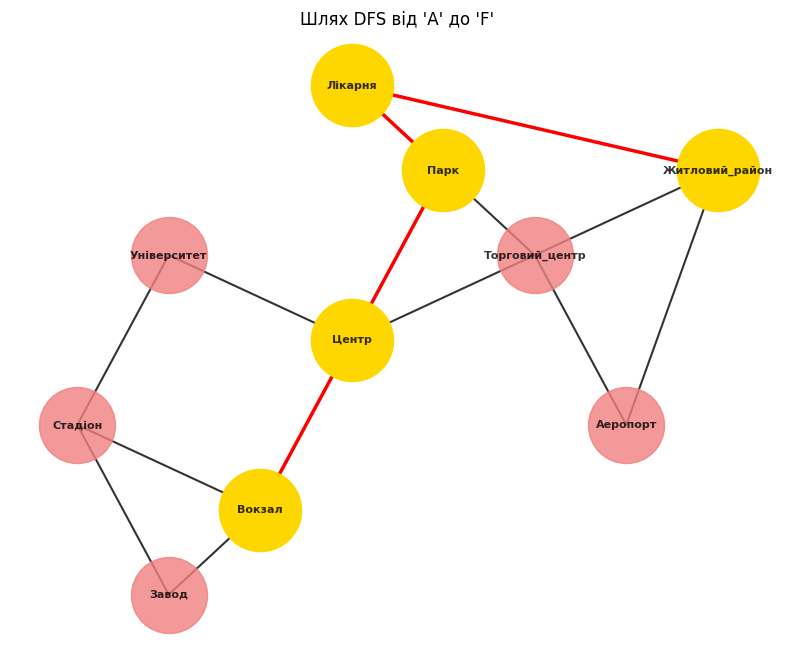

In [21]:
# Пошук шляху від 'A' до 'F' за допомогою DFS
try:
    start_time_dfs = time.time()
    dfs_path_custom = dfs_iterative(transport_graph, src=source_node, dst=target_node)
    end_time_dfs = time.time()
    print(f"Один з можливих шляхів від '{nodes_data[source_node]['label']}' до '{nodes_data[target_node]['label']}' (DFS iterative): {dfs_path_custom}")
    print(f"Час виконання DFS iterative: {end_time_dfs - start_time_dfs:.6f} сек")

    # Візуалізація шляху DFS
    plt.figure(figsize=(10, 8))
    ax_dfs = plt.gca()
    plot_graph_custom(transport_graph, 
                      highlighted_path=dfs_path_custom,
                      title=f"Шлях DFS від '{source_node}' до '{target_node}'", 
                      ax=ax_dfs,
                      pos=pos,
                      node_labels_viz=node_labels)
    plt.show()

except nx.NetworkXNoPath as e:
    print(e)
except KeyError as e:
    print(e)

### 3.3. Пошук в Ширину (BFS) – Найкоротший маршрут за кількістю зупинок
Пошук в ширину (BFS) досліджує граф рівень за рівнем і гарантовано знаходить найкоротший шлях за кількістю ребер (зупинок/сегментів маршруту) в незваженому графі.  Функція nx.shortest_path() з weight=None реалізує це.

Найкоротший шлях (за кількістю сегментів) від 'Вокзал' до 'Житловий_район' (BFS iterative): ['A', 'B', 'D', 'F']
Час виконання BFS iterative: 0.000000 сек


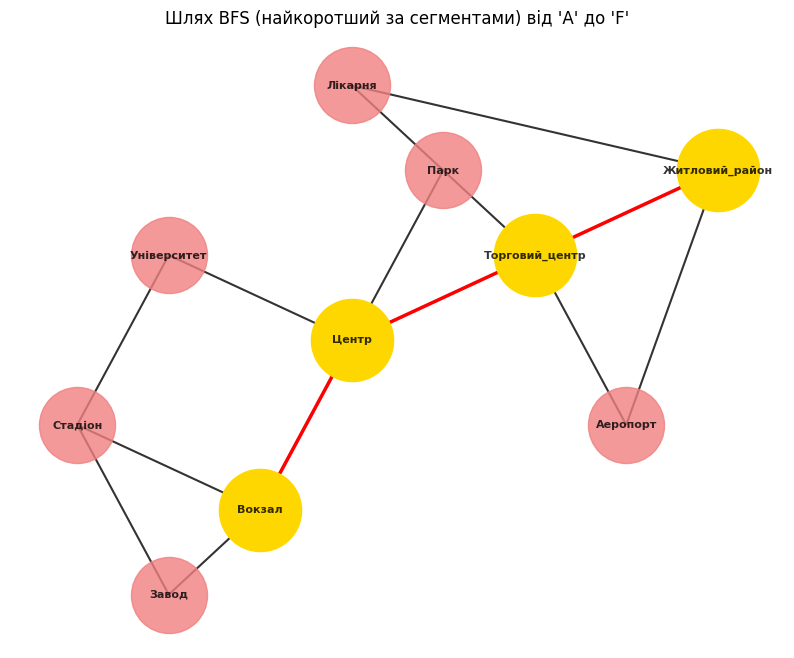

In [23]:
# Пошук шляху від 'A' до 'F' за допомогою BFS (найкоротший за кількістю ребер)
try:
    start_time_bfs = time.time()
    bfs_path_custom = bfs_iterative(transport_graph, src=source_node, dst=target_node)
    end_time_bfs = time.time()
    print(f"Найкоротший шлях (за кількістю сегментів) від '{nodes_data[source_node]['label']}' до '{nodes_data[target_node]['label']}' (BFS iterative): {bfs_path_custom}")
    print(f"Час виконання BFS iterative: {end_time_bfs - start_time_bfs:.6f} сек")

    # Візуалізація шляху BFS
    plt.figure(figsize=(10, 8))
    ax_bfs = plt.gca()
    plot_graph_custom(transport_graph, 
                      highlighted_path=bfs_path_custom,
                      title=f"Шлях BFS (найкоротший за сегментами) від '{source_node}' до '{target_node}'", 
                      ax=ax_bfs,
                      pos=pos,
                      node_labels_viz=node_labels)
    plt.show()

except nx.NetworkXNoPath as e:
    print(e)
except KeyError as e:
    print(e)

### 3.4. Порівняння шляхів: DFS проти BFS у транспортній мережі

Порівняємо шляхи від Центрального Вокзалу (A) до Спального Району (F):

* DFS (один з можливих шляхів): Залежить від порядку обходу сусідів. Наприклад, міг бути знайдений шлях 4 сегменти або 3 сегменти. Перший шлях може бути не найкоротшим.
* BFS (найкоротший за кількістю сегментів): Гарантовано знайде шлях з мінімальною кількістю сегментів. У нашій мережі це ['A', 'B', 'D', 'F'] – всі вони мають 3 сегменти.

Чому шляхи такі:
* DFS: Прагне "заглибитися". Якщо перший обраний напрямок веде довгим шляхом, DFS піде ним. Наприклад, якщо з 'A' він спочатку йде в 'B', потім з 'B' в 'E' (замість 'D'), то шлях може вийти довшим.    
* BFS: Досліджує "вшир". Спочатку всі локації на відстані 1 сегмента від 'A' (B, C), потім всі на відстані 2 сегментів (D, E через C; D через B), і так далі, доки не знайде 'F'. Це гарантує, що знайдений шлях буде найкоротшим за кількістю пересадок/сегментів.

У нашій мережі є кілька шляхів з 3 сегментами від A до F. BFS знайде один з них. DFS може знайти довший шлях, якщо він "заглибиться" в нього першим.

## Розділ 4: Оптимізація маршрутів – Найшвидші шляхи за алгоритмом Дейкстри

### 4.1. Додавання ваг: час у дорозі між локаціями
Досі ми розглядали лише кількість сегментів шляху. Але в реальності різні ділянки маршруту займають різний час. Введемо ваги ребер, що представлятимуть середній час у дорозі (в хвилинах) між двома локаціями. Менша вага означатиме швидший зв'язок. Додавання ваг до ребер у NetworkX здійснюється через атрибути ребер.

In [24]:
# Додавання ваг (час у хвилинах) до ребер
weights_data = {
    ('A', 'B'): 5,
    ('A', 'I'): 20,
    ('A', 'H'): 10,
    ('B', 'C'): 8,
    ('B', 'E'): 7,
    ('B', 'D'): 22,
    ('C', 'H'): 8,
    ('D', 'E'): 6,
    ('D', 'J'): 15,
    ('D', 'F'): 10,
    ('E', 'G'): 10,
    ('F', 'J'): 20,
    ('F', 'G'): 8,
    ('H', 'I'): 15
}

for edge, weight_value in weights_data.items():
    # Переконуємося, що додаємо вагу для обох напрямків, оскільки граф неорієнтований
    if transport_graph.has_edge(*edge):
        transport_graph.edges[edge]['time'] = weight_value

print("\nРебра графа з вагами (час у хвилинах):")
for u, v, data in transport_graph.edges(data=True):
    print(f"Сполучення ({nodes_data[u]['label']} ({u}) -> {nodes_data[v]['label']} ({v})), Час: {data.get('time', 'Не вказано')} хв")


Ребра графа з вагами (час у хвилинах):
Сполучення (Вокзал (A) -> Центр (B)), Час: 5 хв
Сполучення (Вокзал (A) -> Завод (I)), Час: 20 хв
Сполучення (Вокзал (A) -> Стадіон (H)), Час: 10 хв
Сполучення (Центр (B) -> Університет (C)), Час: 8 хв
Сполучення (Центр (B) -> Парк (E)), Час: 7 хв
Сполучення (Центр (B) -> Торговий_центр (D)), Час: 22 хв
Сполучення (Університет (C) -> Стадіон (H)), Час: 8 хв
Сполучення (Торговий_центр (D) -> Парк (E)), Час: 6 хв
Сполучення (Торговий_центр (D) -> Аеропорт (J)), Час: 15 хв
Сполучення (Торговий_центр (D) -> Житловий_район (F)), Час: 10 хв
Сполучення (Парк (E) -> Лікарня (G)), Час: 10 хв
Сполучення (Житловий_район (F) -> Аеропорт (J)), Час: 20 хв
Сполучення (Житловий_район (F) -> Лікарня (G)), Час: 8 хв
Сполучення (Стадіон (H) -> Завод (I)), Час: 15 хв


### 4.2. Алгоритм Дейкстри: пошук найшвидшого маршруту
Алгоритм Дейкстри знаходить найкоротші шляхи у зваженому графі, де "найкоротший" означає шлях з мінімальною сумою ваг ребер (у нашому випадку – найменший загальний час у дорозі).  NetworkX надає nx.all_pairs_dijkstra_path() для обчислення таких шляхів між усіма парами вузлів, використовуючи вказаний атрибут ваги.

In [25]:
# Обчислення всіх найшвидших шляхів за допомогою алгоритму Дейкстри (за атрибутом 'time')
all_fastest_paths_dijkstra = dict(nx.all_pairs_dijkstra_path(transport_graph, weight='time'))
all_fastest_path_lengths_dijkstra = dict(nx.all_pairs_dijkstra_path_length(transport_graph, weight='time'))

# Створення списку для таблиці
table_data = []
for source_loc, paths_dict in all_fastest_paths_dijkstra.items():
    source_label = transport_graph.nodes[source_loc]['label']
    for target_loc, path_val in paths_dict.items():
        if source_loc != target_loc:  # Не показуємо шляхи до самого себе
            target_label = transport_graph.nodes[target_loc]['label']
            path_length_val = all_fastest_path_lengths_dijkstra[source_loc][target_loc]
            # Перетворюємо список вузлів у шлях із назвами локацій
            path_labels = [transport_graph.nodes[node]['label'] for node in path_val]
            table_data.append({
                'Від локації': source_label,
                'До локації': target_label,
                'Маршрут': ' -> '.join(path_labels),
                'Час (хв)': path_length_val
            })

# Створення DataFrame для таблиці
df = pd.DataFrame(table_data)

# Відображення таблиці
print("\nНайшвидші маршрути (Дейкстра) між усіма парами локацій:")
display(df)


Найшвидші маршрути (Дейкстра) між усіма парами локацій:


,Від локації,До локації,Маршрут,Час (хв)
0,Вокзал,Центр,Вокзал -> Центр,5
1,Вокзал,Завод,Вокзал -> Завод,20
2,Вокзал,Стадіон,Вокзал -> Стадіон,10
3,Вокзал,Університет,Вокзал -> Центр -> Університет,13
4,Вокзал,Парк,Вокзал -> Центр -> Парк,12
...,...,...,...,...
85,Аеропорт,Лікарня,Аеропорт -> Житловий_район -> Лікарня,28
86,Аеропорт,Університет,Аеропорт -> Торговий_центр -> Парк -> Центр ->...,36
87,Аеропорт,Вокзал,Аеропорт -> Торговий_центр -> Парк -> Центр ->...,33
88,Аеропорт,Завод,Аеропорт -> Торговий_центр -> Парк -> Центр ->...,53


### 4.3. Аналіз ключових "Найшвидших Маршрутів"
Розглянемо найшвидший маршрут від Центрального Вокзалу (A) до Житлового Району (F):


Найшвидший маршрут від 'Вокзал' до 'Житловий_район':
  Маршрут: ['A', 'B', 'E', 'D', 'F']
  Загальний час у дорозі: 28.0 хв
  Час виконання алгоритму Дейкстра: 0.000000 сек


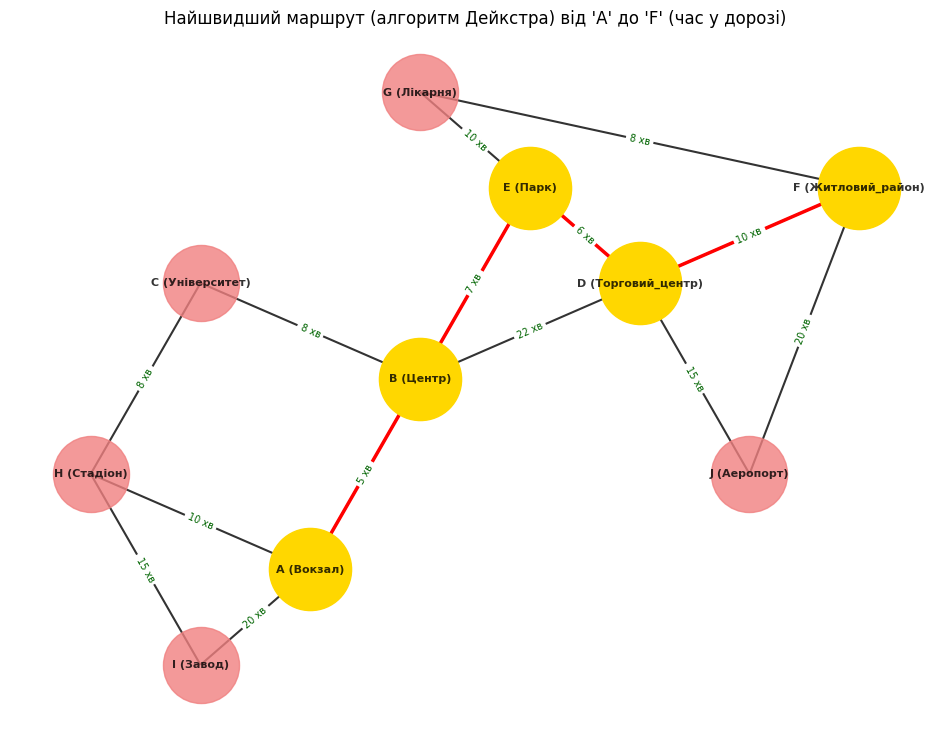

In [28]:
# Перевірка, чи вузли існують, перш ніж викликати dijkstra_heap
if source_node not in transport_graph or target_node not in transport_graph:
    print(f"Один або обидва вузли ({source_node}, {target_node}) відсутні у графі.")
else:
    try:
        start_time_dijkstra = time.time()
        dijkstra_path, dijkstra_length = dijkstra_heap(
            transport_graph, 
            src=source_node, 
            dst=target_node, 
            weight='time'
        )
        end_time_dijkstra = time.time()
        
        print(f"\nНайшвидший маршрут від '{nodes_data[source_node]['label']}' до '{nodes_data[target_node]['label']}':")
        print(f"  Маршрут: {dijkstra_path}")
        print(f"  Загальний час у дорозі: {dijkstra_length} хв")
        print(f"  Час виконання алгоритму Дейкстра: {end_time_dijkstra - start_time_dijkstra:.6f} сек")

        # Візуалізація цього шляху з вагами
        plt.figure(figsize=(12, 9)) # Збільшено розмір
        ax_dijkstra = plt.gca()
        
        # Використовуємо мітки вузлів з nodes_data для більшої інформативності
        custom_labels_for_plot = {node: f"{node} ({attr['label']})" for node, attr in nodes_data.items()}
        
        plot_graph_custom(transport_graph, 
                          highlighted_path=dijkstra_path,
                          title=f"Найшвидший маршрут (алгоритм Дейкстра) від '{source_node}' до '{target_node}' (час у дорозі)", 
                          ax=ax_dijkstra,
                          pos=pos, # Використовуємо оригінальні позиції
                          node_labels_viz=custom_labels_for_plot, # Використовуємо кастомні мітки
                          edge_labels_attr='time') # Показуємо ваги ребер (час)
        plt.show()

    except nx.NetworkXNoPath as e:
        print(e)
    except KeyError as e:
        print(e)

BFS міг знайти шлях (3 сегменти). Час: (A,B) 5 + (B,D) 22 + (D,F) 10 = 37 хв.\
Алгоритм Дейкстри знайде шлях ['A', 'B', 'E', 'D', 'F'] з часом 28 хвилини, оскільки це найменший сумарний час.\
Це демонструє, що найкоротший шлях за кількістю зупинок (BFS) не завжди є найшвидшим за часом (Дейкстра).

## Розділ 5: Висновки – Навігація містом за допомогою графів

### 5.1. Підсумок Результатів
Цей звіт продемонстрував, як графо-теоретичні методи можуть бути застосовані для аналізу та оптимізації транспортних мереж:
* Моделювання та Аналіз Мережі: Було створено граф, що представляє транспортну мережу міста. Аналіз базових характеристик (кількість локацій, сполучень, ступені локацій) виявив ключові вузли та загальну структуру мережі.
* Пошук Маршрутів (DFS та BFS): Алгоритми DFS та BFS були використані для знаходження можливих маршрутів. Було показано, що BFS знаходить маршрут з найменшою кількістю проміжних зупинок, тоді як DFS досліджує один з можливих шляхів, який не обов'язково є найкоротшим за кількістю сегментів.
* Оптимізація Маршрутів (Алгоритм Дейкстри): Шляхом додавання ваг (час у дорозі) до транспортних сполучень та застосування алгоритму Дейкстри було знайдено найшвидші маршрути. Це продемонструвало, що найкоротший маршрут за кількістю зупинок не завжди є найшвидшим за часом.

### 5.2. Практичне Значення Графових Алгоритмів для Транспорту

Графові алгоритми є незамінними для вирішення широкого кола транспортних задач:
* Навігаційні системи: Пошук оптимальних маршрутів для автомобілів, громадського транспорту, пішоходів (враховуючи відстань, час, вартість, затори).
* Логістика: Планування маршрутів доставки, оптимізація ланцюгів постачання.
* Проектування транспортних мереж: Аналіз зв'язності, виявлення "вузьких місць", планування розвитку інфраструктури.
* Управління трафіком: Моделювання транспортних потоків, прогнозування заторів.

Використання інструментів, таких як NetworkX, дозволяє ефективно реалізовувати ці алгоритми та отримувати цінні інсайти для прийняття рішень.